## Lap Ev

In [1]:
# When you are executing on SN labs please uncomment the below lines and then run all cells.Next again Restart the kernel and run all cells.
#%pip install  findspark
#!pip install findspark
import findspark
findspark.init()

In [2]:
# Pandas is a popular data science package for Python. In this lab, we use Pandas to load a CSV file from disc to a pandas dataframe in memory.
import pandas as pd
import matplotlib.pyplot as plt
# pyspark is the Spark API for Python. In this lab, we use pyspark to initialize the spark context. 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

Task 1: Creating the spark session and context

In [3]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
spark


#### Task 2: Importing Spark ML libraries

In this exercise we will import 4 SparkML functions. 


1. (Feature library) VectorAssembler(): This function is used to create feature vectors from dataframes/raw data. These feature vectors are required to train a ML model or perform any statistical operations. 
2. (Stat library) Correlation(): This function is from the statistics library within SparkML. This function is used to calculate correlation between feature vectors. 
3. (Feature library) Normalized(): This function is used to normalize features. Normalizing features leads to better ML model convergence and training results. 
4. (Regression Library) LinearRegression(): This function is used to create a Linear Regression model and train it. 


In [5]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

Exercise 2 - Loading the data and Creating Feature Vectors¶






In this section, you will first read the CSV file into a pandas dataframe and then read it into a Spark dataframe

Pandas is a library used for data manipulation and analysis. Pandas offers data structures and operations for creating and manipulating Data Series and DataFrame objects. Data can be imported from various data sources, e.g., Numpy arrays, Python dictionaries and CSV files. Pandas allows you to manipulate, organize and display the data.

In this example we use a dataset that contains information about cars.

Task 1: Loading data into a Pandas DataFrame

In [6]:
# Read the file using `read_csv` function in pandas
cars = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-BD0225EN-SkillsNetwork/labs/data/cars.csv')
# Preview a few records
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [7]:
cars2 = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-BD0225EN-SkillsNetwork/labs/data/cars2.csv', header=None, names=["mpg", "hp", "weight"])
cars2.head()

,mpg,hp,weight
0,18.0,130.0,3504.0
1,15.0,165.0,3693.0
2,18.0,150.0,3436.0
3,16.0,150.0,3433.0
4,17.0,140.0,3449.0


Task 2: Loading data into a Spark DataFrame¶

In [11]:
# We use the `createDataFrame` function to load the data into a spark dataframe
sdf = spark.createDataFrame(cars2)

In [12]:
# Let us look at the schema of the loaded spark dataframe
sdf.printSchema()

root
 |-- mpg: double (nullable = true)
 |-- hp: double (nullable = true)
 |-- weight: double (nullable = true)



Task 3: Converting data frame columns into feature vectors
In this task we use the VectorAssembler() function to convert the dataframe columns into feature vectors. For our example, we use the horsepower ("hp) and weight of the car as input features and the miles-per-gallon ("mpg") as target labels.

In [13]:
assembler = VectorAssembler(
    inputCols=["hp", "weight"],
    outputCol="features")

output = assembler.transform(sdf).select('features','mpg')

In [14]:
train, test = output.randomSplit([0.75, 0.25])

Exercise 3 - Basic stats and feature engineering¶






In this exercise, we determine the correlation between feature vectors and normalize the features.

Task 1: Correlation
Spark ML has inbuilt Correlation function as part of the Stat library. We use the correlation function to determine the different types of correlation between the 2 features - "hp" and "weight".

In [15]:
r1 = Correlation.corr(train, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.86933081],
             [0.86933081, 1.        ]])


In [16]:
r2 = Correlation.corr(train, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Spearman correlation matrix:
DenseMatrix([[1.        , 0.88682028],
             [0.88682028, 1.        ]])


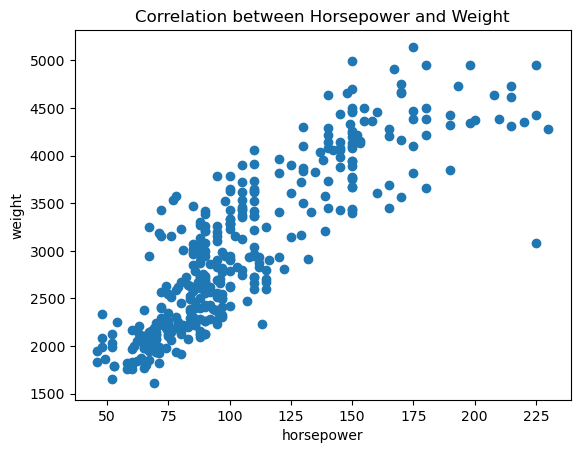

In [17]:
plt.figure()
plt.scatter(cars2["hp"], cars2["weight"])
plt.xlabel("horsepower")
plt.ylabel("weight")
plt.title("Correlation between Horsepower and Weight")
plt.show()

Text(0.5, 0, 'Horsepower')

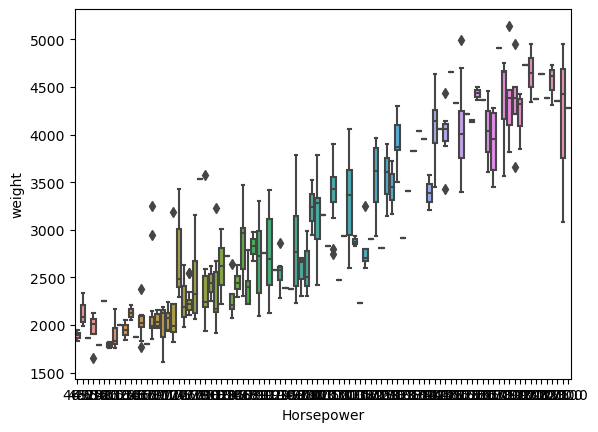

In [24]:
import seaborn as sns

sns.boxplot(x="hp", y="weight", data=cars2)
plt.xlabel("Horsepower")

Task 2: Normalization¶
In order for better model training and convergence, it is a good practice to normalize feature vectors.

In [25]:
normalizer = Normalizer(inputCol="features", outputCol="features_normalized", p=1.0)
train_norm = normalizer.transform(train)
print("Normalized using L^1 norm")
train_norm.show(5, truncate=False)

Normalized using L^1 norm
+-------------+----+-----------------------------------------+
|features     |mpg |features_normalized                      |
+-------------+----+-----------------------------------------+
|[46.0,1835.0]|26.0|[0.024455077086656035,0.9755449229133439]|
|[86.0,2220.0]|23.0|[0.0372940156114484,0.9627059843885516]  |
|[87.0,2672.0]|25.0|[0.031533164189923885,0.9684668358100761]|
|[88.0,2130.0]|27.0|[0.03967538322813345,0.9603246167718665] |
|[88.0,2130.0]|27.0|[0.03967538322813345,0.9603246167718665] |
+-------------+----+-----------------------------------------+
only showing top 5 rows



Task 2: Standard Scaling
This is a standard practice to scale the features such that all columns in the features have zero mean and unit variance.

In [26]:
standard_scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
train_model = standard_scaler.fit(train)
train_scaled = train_model.transform(train)
train_scaled.show(5, truncate=False)

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[46.0,1835.0]|26.0|[1.2086548908002506,2.1434693831396805]|
|[86.0,2220.0]|23.0|[2.2596591436700337,2.5931891174768884]|
|[87.0,2672.0]|25.0|[2.2859342499917785,3.1211717666208316]|
|[88.0,2130.0]|27.0|[2.312209356313523,2.488059828930528]  |
|[88.0,2130.0]|27.0|[2.312209356313523,2.488059828930528]  |
+-------------+----+---------------------------------------+
only showing top 5 rows



In [27]:
test_scaled = train_model.transform(test)
test_scaled.show(5, truncate=False)

+--------------+----+---------------------------------------+
|features      |mpg |features_scaled                        |
+--------------+----+---------------------------------------+
|[72.0,2408.0] |22.0|[1.8918076551656096,2.8127925202181747]|
|[85.0,2587.0] |21.0|[2.233384037348289,3.0218829941048244] |
|[88.0,3139.0] |18.0|[2.312209356313523,3.666675963855835]  |
|[90.0,2264.0] |28.0|[2.364759568957012,2.644585658543998]  |
|[150.0,3761.0]|15.0|[3.941265948261687,4.393236158031792]  |
+--------------+----+---------------------------------------+
only showing top 5 rows



Exercise 4 - Building and Training a Linear Regression Model¶

Task 1: Create and Train model
We can create the model using the LinearRegression() class and train using the fit() function.

In [28]:
# Create a LR model
lr = LinearRegression(featuresCol='features_scaled', labelCol='mpg', maxIter=100)

# Fit the model
lrModel = lr.fit(train_scaled)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
#trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R-squared: %f" % trainingSummary.r2)

Coefficients: [-1.5184573843361953,-5.1351081257383635]
Intercept: 45.44007718181415
RMSE: 4.113075
R-squared: 0.713296


Task 2: Predict on new data¶
Once a model is trained, we can then transform() new unseen data (for eg. the test data) to generate predictions. In the below cell, notice the "prediction" column that contains the predicted "mpg".

In [29]:
lrModel.transform(test_scaled).show(5)

+--------------+----+--------------------+------------------+
|      features| mpg|     features_scaled|        prediction|
+--------------+----+--------------------+------------------+
| [72.0,2408.0]|22.0|[1.89180765516560...|28.123454151495746|
| [85.0,2587.0]|21.0|[2.23338403734828...|26.531082780185795|
| [88.0,3139.0]|18.0|[2.31220935631352...|23.100308274142993|
| [90.0,2264.0]|28.0|[2.36475956895701...|28.269057247751267|
|[150.0,3761.0]|15.0|[3.94126594826168...|16.895690105646747|
+--------------+----+--------------------+------------------+
only showing top 5 rows



Print the correlation matrix for the test dataset split we created above. 

In [30]:
r1 = Correlation.corr(test, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.85392147],
             [0.85392147, 1.        ]])


In [32]:
normalizer_l2 = Normalizer(inputCol="features", outputCol="features_normalized", p=2.0)
train_norm_l2 = normalizer_l2.transform(train)
print("Normalized using L^1 norm\n"+str(train_norm_l2))
train_norm_l2.show(5, truncate=False)

Normalized using L^1 norm
DataFrame[features: vector, mpg: double, features_normalized: vector]
+-------------+----+-----------------------------------------+
|features     |mpg |features_normalized                      |
+-------------+----+-----------------------------------------+
|[46.0,1835.0]|26.0|[0.025060247064771873,0.9996859426925301]|
|[86.0,2220.0]|23.0|[0.03870970399718558,0.9992504985319999] |
|[87.0,2672.0]|25.0|[0.03254263484012658,0.9994703481933128] |
|[88.0,2130.0]|27.0|[0.04127933931642943,0.9991476448181215] |
|[88.0,2130.0]|27.0|[0.04127933931642943,0.9991476448181215] |
+-------------+----+-----------------------------------------+
only showing top 5 rows

